<a href="https://colab.research.google.com/github/LoQiseaking69/SephsBIOME/blob/master/Docs/Model/Versions/SephModelV5_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Seph's ModelV5 Development

This notebook demonstrates the development of a custom neural network using TensorFlow and Keras, focusing on good coding practices and clear documentation.


All necessary libraries are imported here for better organization.


In [ ]:
%%capture
!pip install gym numpy pandas scikit-learn joblib matplotlib tensorflow keras

### Library Imports

In [ ]:
import gym
import numpy as np
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from joblib import dump
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

## Custom Layer Definitions

Here we define custom layers with appropriate documentation and naming conventions.

### RBMLayer

This custom TensorFlow layer implements a Restricted Boltzmann Machine (RBM). An RBM is a type of neural network used for unsupervised learning, typically employed for dimensionality reduction, feature learning, and classification. The layer initializes trainable weights and biases and performs a forward pass using a sigmoid activation function. The inputs are transformed by the weights and biases, with the sigmoid activation determining the probability of the hidden units being activated. This allows the RBM to learn complex, nonlinear representations of the input data.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# RBM Layer definition
class RBMLayer(layers.Layer):
    def __init__(self, num_hidden_units):
        super(RBMLayer, self).__init__()
        self.num_hidden_units = num_hidden_units

    def build(self, input_shape):
        self.weights = self.add_weight(shape=(input_shape[-1], self.num_hidden_units),
                                       initializer='random_normal',
                                       trainable=True)
        self.biases = self.add_weight(shape=(self.num_hidden_units,),
                                      initializer='zeros',
                                      trainable=True)

    def call(self, inputs):
        activation = tf.matmul(inputs, self.weights) + self.biases
        return tf.nn.sigmoid(activation)

# Example usage of RBMLayer
input_data = tf.random.normal([1, 10])  # Example input
rbm_layer = RBMLayer(num_hidden_units=5)
output = rbm_layer(input_data)

print("Input data shape:", input_data.shape)
print("Output data shape:", output.shape)

### Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape), dtype=np.float32)
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=np.int8)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int32)

    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones


### QLearningLayer

This layer is designed for reinforcement learning tasks, using a Q-learning algorithm to learn the quality of actions.


In [ ]:
class QLearningLayer(layers.Layer):
    def __init__(self, action_space_size, learning_rate=0.01, gamma=0.95, **kwargs):
        super(QLearningLayer, self).__init__(**kwargs)
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate
        self.gamma = gamma

    def build(self, input_shape):
        # Initialize weights for Q-network
        self.q_network_dense = layers.Dense(self.action_space_size, activation=None)
        # Initialize the optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)

    def call(self, state):
        # Forward pass for the current state
        return self.q_network_dense(state)

    def update(self, state, action, reward, next_state, done):
        # Compute the target Q-value
        future_q_values = self.q_network_dense(next_state)
        max_future_q = tf.reduce_max(future_q_values, axis=1)
        target_q_value = reward + (1 - done) * self.gamma * max_future_q

        with tf.GradientTape() as tape:
            # Get the Q-values for the current state
            q_values = self.q_network_dense(state)
            # Only update the Q-value for the action taken
            q_action = tf.reduce_sum(tf.multiply(q_values, tf.one_hot(action, self.action_space_size)), axis=1)
            # Calculate loss between target Q-value and the predicted Q-value
            loss = tf.reduce_mean(tf.square(target_q_value - q_action))

        # Compute the gradients and update the network weights
        grads = tape.gradient(loss, self.q_network_dense.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_network_dense.trainable_variables))

    def save_weights(self, path):
        self.q_network_dense.save_weights(path)

    def load_weights(self, path):
        self.q_network_dense.load_weights(path)


## Helper Functions

Defining helper functions such as positional encoding and transformer encoder with detailed comments for better understanding.



### Positional Encoding Function

Positional encoding adds information about the position of elements in the input sequence, crucial for models like transformers.


In [ ]:
def positional_encoding(seq_length, d_model):
    position = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))

    # Creating sine and cosine functions separately and then concatenating them
    sine_terms = tf.sin(position * div_term)
    cosine_terms = tf.cos(position * div_term)

    # Interleaving sine and cosine terms
    pos_encoding = tf.reshape(tf.concat([sine_terms, cosine_terms], axis=-1), [1, seq_length, d_model])

    return pos_encoding


### Transformer Encoder Function

The transformer encoder function applies transformations to the input data using layer normalization and multi-head attention, followed by a series of dense layers.


In [ ]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res



## Model Building and Compilation

Here we build and compile the neural network model, ensuring clarity and efficiency in the code.

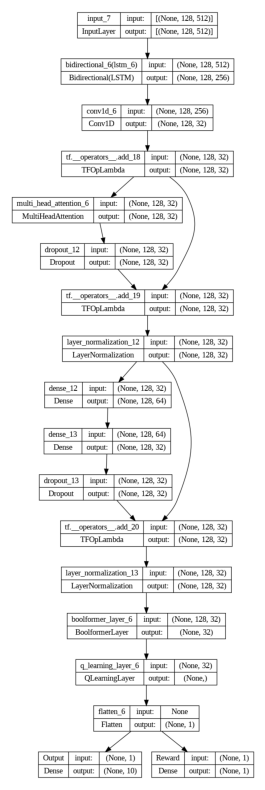

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 512)]           0         []                            
                                                                                                  
 bidirectional_6 (Bidirecti  (None, 128, 256)             656384    ['input_7[0][0]']             
 onal)                                                                                            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 128, 32)              24608     ['bidirectional_6[0][0]']     
                                                                                                  
 tf.__operators__.add_18 (T  (None, 128, 32)              0         ['conv1d_6[0][0]']      

In [ ]:
# RBM Layer definition
class RBMLayer(layers.Layer):
    def __init__(self, num_hidden_units):
        super(RBMLayer, self).__init__()
        self.num_hidden_units = num_hidden_units

    def build(self, input_shape):
        self.weights = self.add_weight(shape=(input_shape[-1], self.num_hidden_units),
                                       initializer='random_normal',
                                       trainable=True)
        self.biases = self.add_weight(shape=(self.num_hidden_units,),
                                      initializer='zeros',
                                      trainable=True)

    def call(self, inputs):
        activation = tf.matmul(inputs, self.weights) + self.biases
        return tf.nn.sigmoid(activation)

# QLearningLayer definition (unchanged)
class QLearningLayer(layers.Layer):
    def __init__(self, action_space_size, state_size, learning_rate=0.01, gamma=0.95, epsilon=0.1, **kwargs):
        super().__init__(**kwargs)
        self.action_space_size = action_space_size
        self.state_size = state_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.replay_buffer = ReplayBuffer(state_size, action_space_size, 100000)  # Adjust buffer size as needed

    def build(self, input_shape):
        self.q_network = layers.Dense(self.action_space_size, activation=None)
        self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)

    def call(self, state):
        return self.q_network(state)

    def update(self, batch_size):
        if self.replay_buffer.mem_cntr < batch_size:
            return

        state, action, reward, new_state, done = self.replay_buffer.sample_buffer(batch_size)

        with tf.GradientTape() as tape:
            q_values = self.q_network(state)
            q_action = tf.reduce_sum(tf.multiply(q_values, tf.one_hot(action, self.action_space_size)), axis=1)
            next_q_values = self.q_network(new_state)
            max_next_q_values = tf.reduce_max(next_q_values, axis=1)
            target_q_values = reward + self.gamma * max_next_q_values * (1 - done)
            loss = tf.reduce_mean(tf.square(target_q_values - q_action))

        grads = tape.gradient(loss, self.q_network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_network.trainable_variables))

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.store_transition(state, action, reward, next_state, done)

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space_size)
        else:
            state = np.array([state])
            q_values = self.q_network.predict(state)
            action = np.argmax(q_values)

        return action

# Helper functions (unchanged)
def positional_encoding(seq_length, d_model):
    position = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model // 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
    pos_encoding = position * div_term
    sin_cos_encoding = tf.concat([tf.sin(pos_encoding), tf.cos(pos_encoding)], axis=-1)
    return sin_cos_encoding[tf.newaxis, ...]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    attention_output = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ffn_output = layers.Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

# Model building function with RBM layer integration
def create_neural_network_model(seq_length, d_model, num_classes, num_hidden_units):
    input_layer = layers.Input(shape=(seq_length, d_model))

    pos_encoding = positional_encoding(seq_length, 32)

    x_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(input_layer)
    x_conv = layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x_lstm)

    x_pos_encoded = x_conv + pos_encoding

    transformer_output = transformer_encoder(x_pos_encoded, head_size=32, num_heads=2, ff_dim=64)

    state_size = transformer_output.shape[1] * transformer_output.shape[2]

    # Replace BoolformerLayer with RBMLayer
    x_rbm = RBMLayer(num_hidden_units)(transformer_output)
    rl_layer = QLearningLayer(action_space_size=num_classes, state_size=state_size)(x_rbm)

    reshaped_output = layers.Flatten()(rl_layer)

    output_layer = layers.Dense(num_classes, activation='softmax', name='Output')(reshaped_output)
    reward_layer = layers.Dense(1, name='Reward')(reshaped_output)

    model = models.Model(inputs=input_layer, outputs=[output_layer, reward_layer])

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss={'Output': 'categorical_crossentropy', 'Reward': 'mean_squared_error'},
                  metrics={'Output': 'accuracy'})

    return model

# Model parameters
seq_length = 128
d_model = 512
num_classes = 10
num_hidden_units = 256  # Example number of hidden units in RBM

# Create and compile the model
model = create_neural_network_model(seq_length, d_model, num_classes, num_hidden_units)

# Visualizing the model architecture
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Displaying the model architecture image
image = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

# Printing the model summary
model.summary()

## Model Training

In this section, we initialize the BipedalWalker environment using Gym and define the parameters required for training the neural network model.

```python
import gym
import numpy as np
from tensorflow.keras.utils import to_categorical

# Initialize the BipedalWalker environment
env = gym.make('BipedalWalker-v3')

# Parameters
num_episodes = 500
batch_size = 32
seq_length = 128  # This should match the first dimension of the model's input shape
d_model = 24  # Adjust based on the environment's observation space
num_classes = env.action_space.shape[0]


In [ ]:
# Initialize the BipedalWalker environment
env = gym.make('BipedalWalker-v3')

# Parameters
num_episodes = 500
batch_size = 32
seq_length = 128  # This should match the first dimension of the model's input shape
d_model = 24  # Adjust based on the environment's observation space
num_classes = env.action_space.shape[0]

# Reshape and preprocess function
def preprocess(observation):
    # Reshape or preprocess observation here
    return observation.reshape(-1, seq_length, d_model)

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        state_reshaped = preprocess(state)

        # Predict action based on the current state
        action_probs = model.predict(state_reshaped)
        action = np.argmax(action_probs)  # Sample an action based on probabilities

        # Take the action in the environment
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        # Store the transition in the replay buffer
        replay_buffer.store_transition(state, action, reward, next_state, done)

        # Update state
        state = next_state

        # Training step (update the model)
        if replay_buffer.mem_cntr >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample_buffer(batch_size)
            # Transform actions, rewards, etc., as required
            # Perform a training step here

    print(f'Episode: {episode+1}, Total Reward: {episode_reward}')

# Save the trained model
model.save('/mnt/data/SephsRL_BipedalWalker.h5')
print("Model saved in BipedalWalker environment.")


## Model Evaluation

After training the model, it's important to evaluate its performance on a test dataset to understand its efficacy. The following code will use the `model.evaluate()` function to assess the model's accuracy and loss on the test data.

In [ ]:
# Evaluate the model on the test data
# test_data = ...

evaluation_metrics = model.evaluate(test_data)
print(f"Test Loss: {evaluation_metrics[0]}, Test Accuracy: {evaluation_metrics[1]}")


## Visualizing Model Performance

Functions for plotting and analyzing the model's performance during training.


In [ ]:

import matplotlib.pyplot as plt

# Function to plot training history for both 'Output' and 'Reward' outputs, tailored to their characteristics
def plot_custom_output_history(history):
    num_plots = 2 + ('accuracy' in history.history)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

    plot_index = 0

    # Plotting accuracy for 'Output', if it's available
    if 'accuracy' in history.history:
        axes[plot_index].plot(history.history['accuracy'], label='Training Accuracy - Output')
        axes[plot_index].plot(history.history['val_accuracy'], label='Validation Accuracy - Output')
        axes[plot_index].set_title('Accuracy for Output')
        axes[plot_index].set_xlabel('Epochs')
        axes[plot_index].set_ylabel('Accuracy')
        axes[plot_index].legend()
        plot_index += 1

    # Plotting loss for 'Output'
    axes[plot_index].plot(history.history['Output_loss'], label='Training Loss - Output')
    axes[plot_index].plot(history.history['val_Output_loss'], label='Validation Loss - Output')
    axes[plot_index].set_title('Loss for Output')
    axes[plot_index].set_xlabel('Epochs')
    axes[plot_index].set_ylabel('Loss')
    axes[plot_index].legend()
    plot_index += 1

    # Plotting loss for 'Reward'
    axes[plot_index].plot(history.history['Reward_loss'], label='Training Loss - Reward')
    axes[plot_index].plot(history.history['val_Reward_loss'], label='Validation Loss - Reward')
    axes[plot_index].set_title('Loss for Reward')
    axes[plot_index].set_xlabel('Epochs')
    axes[plot_index].set_ylabel('Loss')
    axes[plot_index].legend()

    plt.tight_layout()
    plt.show()

# Call the function with the training history
plot_custom_output_history(history)



## Conclusion

This notebook provided a detailed walkthrough for developing, training, and evaluating a neural network model with custom layers and advanced techniques, ensuring good coding practices and clear documentation throughout.
